In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [2]:
data = pd.read_csv("../data/DataWithLocationCleaned.zip")
data.head()

,Port Name,State,Port Code,Border,Date,Measure,Value,position
0,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Truck Containers Full,133,"(48.905266, -95.314404)"
1,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Truck Containers Empty,298,"(48.905266, -95.314404)"
2,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Personal Vehicles,10383,"(48.905266, -95.314404)"
3,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Personal Vehicle Passengers,19459,"(48.905266, -95.314404)"
4,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Pedestrians,2,"(48.905266, -95.314404)"


In [3]:
g1 = data.groupby(['Date','Measure'])[['Value']].sum().reset_index()
g1.head()

,Date,Measure,Value
0,1996-01-01,Bus Passengers,299911
1,1996-01-01,Buses,17873
2,1996-01-01,Pedestrians,3138859
3,1996-01-01,Personal Vehicle Passengers,20181055
4,1996-01-01,Personal Vehicles,7711801


In [4]:
g2 = data.groupby(['Date','Port Name'])[['Value']].sum().reset_index()
g2.head()

,Date,Port Name,Value
0,1996-01-01,Alcan,3416
1,1996-01-01,Alexandria Bay,127628
2,1996-01-01,Ambrose,1598
3,1996-01-01,Andrade,428954
4,1996-01-01,Antler,2526


In [5]:
g2.shape[0]

30598

In [6]:
data.groupby('Port Name')['Value'].sum().reset_index().max()
#Willow Creek is the port with the most influence between the years. Let's do a regression in order to regress the influence

Port Name    Willow Creek
Value          1160786864
dtype: object

In [7]:
g3 = g2[(g2['Port Name'] == 'Willow Creek') & (g2['Value'] != 0)].reset_index(drop=True)
g3.head()

,Date,Port Name,Value
0,2005-04-01,Willow Creek,272
1,2005-05-01,Willow Creek,475
2,2005-06-01,Willow Creek,617
3,2005-07-01,Willow Creek,1016
4,2005-08-01,Willow Creek,1061


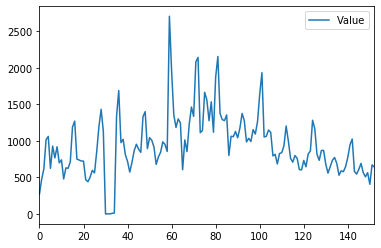

In [8]:
g3.set_index(['Date'], drop=True)
g3.plot()

In [9]:
data.dtypes

Port Name    object
State        object
Port Code     int64
Border       object
Date         object
Measure      object
Value         int64
position     object
dtype: object

In [10]:
data['Date'] = pd.to_datetime(data['Date'])

In [11]:
#We have to consider 2 types of regression : 
#          : 1) One for the traffic at the port
#                  -> use only 'Buses' , 'Personal Vehicles' , 'Rail Containers Empty' , 'Rail Containers Full', 'Trains' , 'Truck Containers Empty' , 'Truck Containers Full' and 'Trucks'
#          : 2) One for the number of persons crossing the port ("immigration")
#                  -> use only 'Bus passengers', 'Pedestrians', 'Personal Vehicle Passengers' and 'Train Passengers'

data.groupby("Measure")[['Value']].sum().reset_index()

,Measure,Value
0,Bus Passengers,143388212
1,Buses,8604318
2,Pedestrians,1056699751
3,Personal Vehicle Passengers,5504073464
4,Personal Vehicles,2584776249
5,Rail Containers Empty,21477185
6,Rail Containers Full,38891558
7,Train Passengers,6287351
8,Trains,912969
9,Truck Containers Empty,64852271


In [12]:
#Create 2 DataFrame : one for the traffic at the ports and one for the persons crossing the ports
persons = data[data['Measure'].isin(['Bus Passengers','Pedestrians','Personal Vehicle Passengers','Train Passengers'])].reset_index().drop(columns=['index'])
traffic = data[~data['Measure'].isin(['Bus Passengers','Pedestrians','Personal Vehicle Passengers','Train Passengers','Truck Containers Empty','Truck Containers Full'])].reset_index().drop(columns=['index'])

In [13]:
#We create a new column named ordinalDate containing the date in ordinal value
#Regression cannot be done on dates.
persons['ordinalDate']=persons['Date'].map(dt.datetime.toordinal)

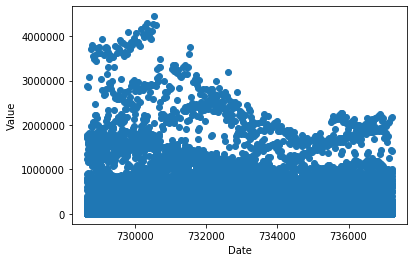

In [130]:
plt.scatter(persons[["ordinalDate"]].iloc[:,0], persons["Value"])
plt.xlabel(X.columns[0])
plt.ylabel('Value')
plt.show()

In [127]:
# We can see that regression isn't working well because a lot of value are equal to 0.
# So, instead we
personsSumDay = persons.groupby("ordinalDate")[['Value']].sum().reset_index()
personsSumDay.head()

,ordinalDate,Value
0,728659,23633628
1,728690,23423798
2,728719,25759922
3,728750,26211553
4,728780,27444210


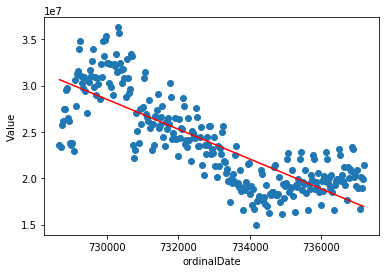

In [151]:
#Total Days linear regression whitout TRAIN TEST

t_d_X = personsSumDay[["ordinalDate"]]
t_d_y = personsSumDay["Value"]

t_d_ln = LinearRegression()
t_d_ln.fit(t_d_X,t_d_y)
t_d_ln_predictions = t_d_ln.predict(t_d_X)

plt.scatter(t_d_X.iloc[:,0], t_d_y)
plt.plot(t_d_X.iloc[:,0], t_d_ln_predictions, 'r')
plt.xlabel(t_d_X.columns[0])
plt.ylabel('Value')
plt.show()
 

In [143]:
t_y_ln_mae = mean_absolute_error(t_y_ln_predictions, t_y_y)
print("MAE = %.2f" % t_y_ln_mae)

MAE = 2324595.55


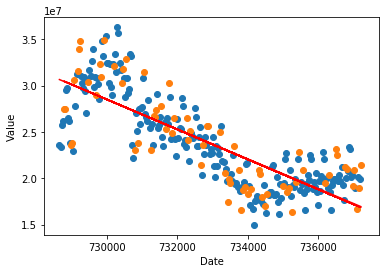

In [152]:
#Total Days linear regression with TRAIN TEST

from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(t_d_X,t_d_y, random_state=1)
# Specify the model
iowa_model = LinearRegression()

# Fit the model with the *TRAINING* data
iowa_model.fit(train_X, train_y)

# Predict with all validation observations
val_predictions = iowa_model.predict(val_X)

plt.scatter(train_X.iloc[:,0], train_y)
plt.scatter(val_X.iloc[:,0], val_y)
plt.plot(val_X.iloc[:,0], val_predictions, 'r')
plt.plot(t_y_X.iloc[:,0], t_y_predictions, 'r')
plt.xlabel(X.columns[0])
plt.ylabel('Value')
plt.show()

In [153]:
t_y_ln_tt_mae = mean_absolute_error(val_predictions, val_y)
print("MAE = %.2f" % t_y_ln_tt_mae)

MAE = 2672216.80


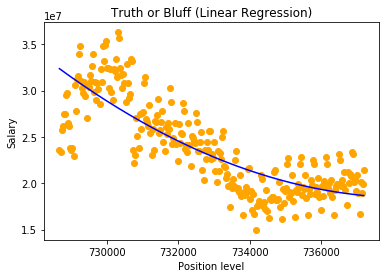

In [159]:
#Total Days polynomial regression whitout TRAIN TEST
 
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=4)

t_d_X_poly = poly_reg.fit_transform(t_d_X)
t_d_pn = LinearRegression()
t_d_pn.fit(X_poly, t_d_y)
t_d_pn_predictions = t_d_pn.predict(t_d_X_poly)

# Visualizing the Polymonial Regression results
def viz_polymonial():
    plt.scatter(t_d_X, t_d_y, color='orange')
    plt.plot(t_d_X, t_d_pn_predictions, color='blue')
    plt.title('Truth or Bluff (Linear Regression)')
    plt.xlabel('Position level')
    plt.ylabel('Salary')
    plt.show()
    return
viz_polymonial()

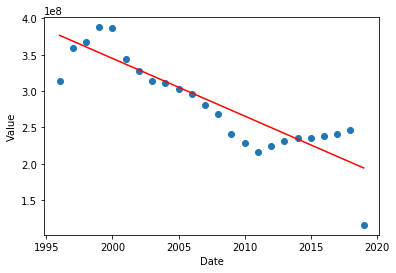

In [156]:
#Total Year linear regression whitout TRAIN TEST

personsSumYear = persons.groupby(persons['Date'].dt.year)[['Value']].sum().reset_index()

t_y_X = personsSumYear[["Date"]]
t_y_y = personsSumYear["Value"]

t_y_ln = LinearRegression()
t_y_ln.fit(X,y)
t_y_ln_pred = t_y_ln.predict(t_y_X)

plt.scatter(t_y_X.iloc[:,0], t_y_y)
plt.plot(t_y_X.iloc[:,0], t_y_ln_pred, 'r')
plt.xlabel(t_y_X.columns[0])
plt.ylabel('Value')
plt.show()

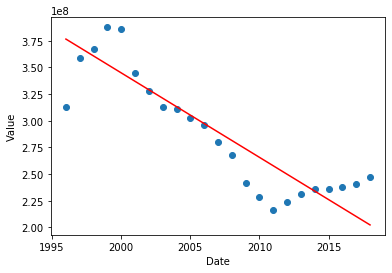

In [158]:
#The year 2019 is a biaised because there is still missing informations. We will take the value out and regress again
#Total Year linear regression whitout TRAIN TEST
personsSumYear = personsSumYear[(personsSumYear['Date'] != 2019) & (personsSumYear['Date'] != 2020)]

t_y_X = personsSumYear[["Date"]]
t_y_y = personsSumYear["Value"]


t_y_ln = LinearRegression()
t_y_ln.fit(X,y)
t_y_ln_pred = t_y_ln.predict(t_y_X)

plt.scatter(t_y_X.iloc[:,0], t_y_y)
plt.plot(t_y_X.iloc[:,0], t_y_ln_pred, 'r')
plt.xlabel(t_y_X.columns[0])
plt.ylabel('Value')
plt.show()


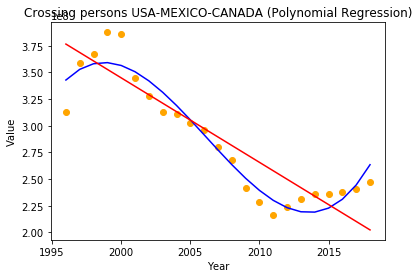

In [160]:
#Total Year polynomial regression without TRAIN TEST

poly_reg = PolynomialFeatures(degree=3)

t_y_X_poly = poly_reg.fit_transform(t_y_X)

t_y_pn = LinearRegression()
t_y_pn.fit(t_y_X_poly, t_y_y)
t_y_pn_pred = t_y_pn.predict(t_y_X_poly)

# Visualizing the Polymonial Regression results
def viz_polymonial():
    plt.scatter(t_y_X, t_y_y, color='orange')
    plt.plot(t_y_X, t_y_pn_pred, color='blue')
    plt.title('Crossing persons USA-MEXICO-CANADA (Polynomial Regression)')
    plt.plot(t_y_X.iloc[:,0], t_y_ln_pred, 'r')
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.show()
    return
viz_polymonial()

In [162]:
#Predict value for 2019 with polynomial and linear regression
print("Polynomial regression of degree 3 :",t_y_pn.predict(poly_reg.fit_transform([[2019]]))[0],"Linear regression :",t_y_ln.predict([[2019]])[0])

Polynomial regression of degree 3 : 288598146.625 Linear regression : 194407325.33766174


In [164]:
#the polynomial is more precise that the linear one for 2019
#But if we try to predict value for 2030, the polynomial regressor will predict very too high value
#Predict value for 2019 with polynomial and linear regression
print("Polynomial regression of degree 3 :",t_y_pn.predict(poly_reg.fit_transform([[2030]]))[0],"Linear regression :",t_y_ln.predict([[2030]])[0])

Polynomial regression of degree 3 : 1117081267.875 Linear regression : 107278120.66064262


In [110]:
canada = persons[persons['Border'] == "US-Canada Border"]
mexico = persons[persons['Border'] == "US-Mexico Border"]

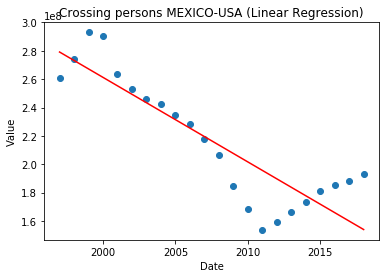

In [165]:
#Mexico Year linear regression without TRAIN TEST

m_year = mexico.groupby(mexico['Date'].dt.year)[['Value']].sum().reset_index()
m_year = m_year[(m_year['Date'] != 2019) & (m_year['Date'] != 1996)]

m_y_X = m_year[["Date"]]
m_y_y = m_year["Value"]

m_y_ln = LinearRegression()
m_y_ln.fit(x_m,y_m)
m_y_ln_predictions = m_y_ln.predict(m_y_X)

plt.scatter(m_y_X.iloc[:,0], m_y_y)
plt.plot(m_y_X.iloc[:,0], m_y_ln_predictions, 'r')
plt.title('Crossing persons MEXICO-USA (Linear Regression)')
plt.xlabel(m_y_X.columns[0])
plt.ylabel('Value')
plt.show()


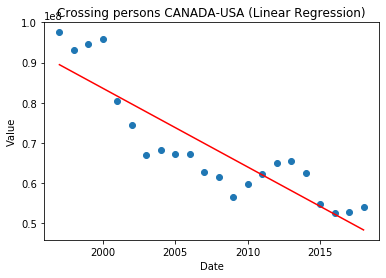

In [166]:
#Canada Year linear regression without TRAIN TEST

c_year = canada.groupby(canada['Date'].dt.year)[['Value']].sum().reset_index()
c_year = c_year[(c_year['Date'] != 2019) & (c_year['Date'] != 1996)]

c_y_X = c_year[["Date"]]
c_y_y = c_year["Value"]

c_y_ln = LinearRegression()
c_y_ln.fit(c_y_X,c_y_y)
c_y_ln_predictions = c_y_ln.predict(c_y_X)

plt.scatter(c_y_X.iloc[:,0], c_y_y)
plt.title('Crossing persons CANADA-USA (Linear Regression)')
plt.plot(c_y_X.iloc[:,0], c_y_ln_predictions, 'r')
plt.xlabel(c_y_X.columns[0])
plt.ylabel('Value')
plt.show()

In [28]:
nn = persons[['Date','Value']]
nn = persons.groupby("Date")[['Value']].sum().reset_index()
nn.head()

,Date,Value
0,1996-01-01,23633628
1,1996-02-01,23423798
2,1996-03-01,25759922
3,1996-04-01,26211553
4,1996-05-01,27444210


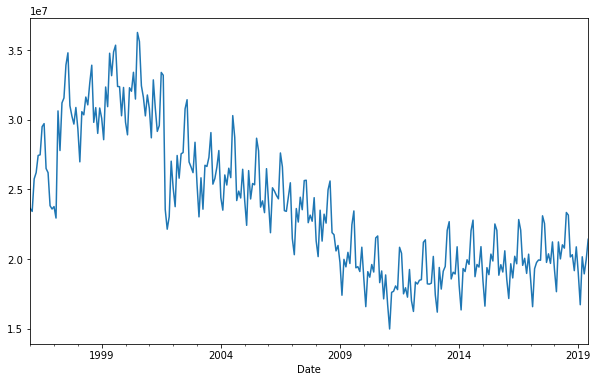

In [29]:
nn['Date'] = pd.to_datetime(nn['Date'])
nn = nn.set_index(['Date'], drop=True)
nn = nn.sort_index()
plt.figure(figsize=(10, 6))
nn['Value'].plot();

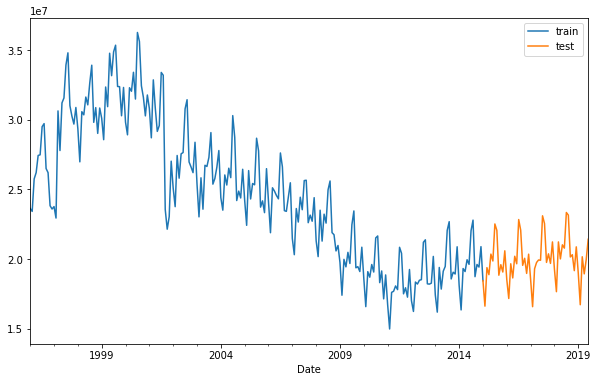

In [53]:
split_date = pd.Timestamp('2015-01-01')
df =  nn['Value']
train = df.loc[:split_date]
test = df.loc[split_date:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);